# 🧪 Exploratory Data Analysis (EDA)
Notebook ini digunakan untuk menuliskan proses EDA (analisis deskriptif dan visualisasi data).
- Gunakan `pandas` dan `matplotlib/seaborn`
- Tampilkan statistik deskriptif
- Visualisasi distribusi, korelasi, outlier, dll.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\qinth\AppData\Local\Temp\ipykernel_18904\1131804247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tcr.head(15), x='TCR', y='product', palette='viridis')


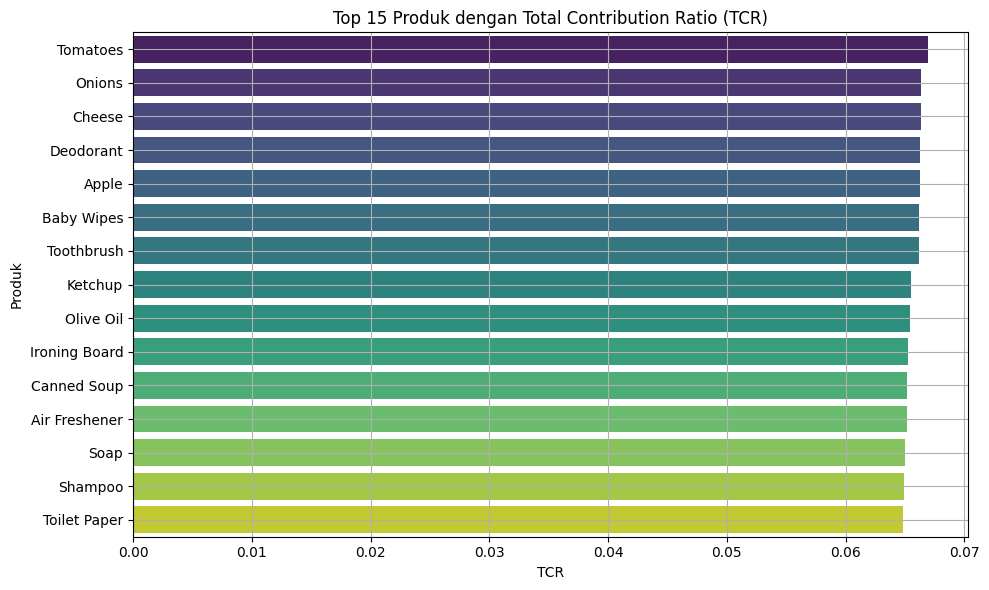

In [ ]:
# Ambil 15 produk dengan TCR tertinggi
plt.figure(figsize=(10, 6))
sns.barplot(data=tcr.head(15), x='TCR', y='product', palette='viridis')
plt.title('Top 15 Produk dengan Total Contribution Ratio (TCR)')
plt.xlabel('TCR')
plt.ylabel('Produk')
plt.grid(True)
plt.tight_layout()
plt.show()

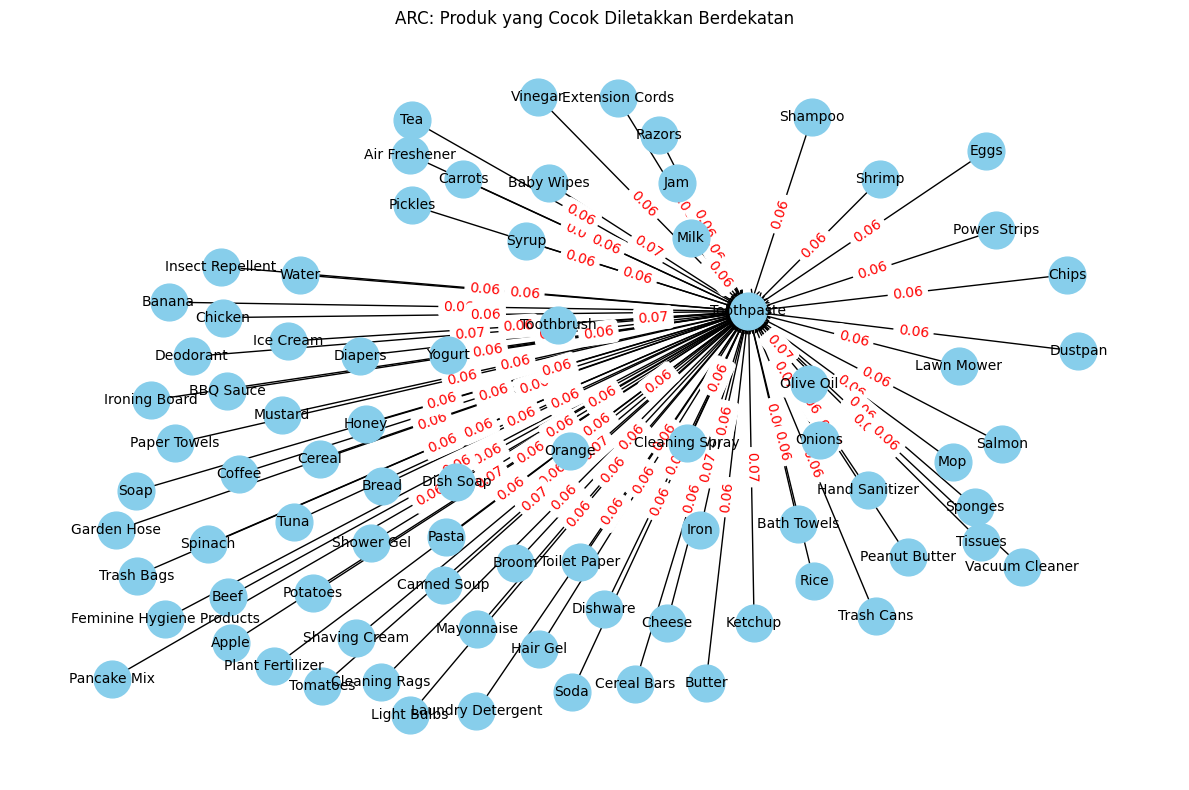

In [ ]:
import networkx as nx

# Buat graph dari ARC
G = nx.DiGraph()

# Tambahkan edge dari ARC (arah: antecedent → consequent)
for i, row in arc_chart.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'], label=f"{row['confidence']:.2f}")

# Visualisasi
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15)
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("ARC: Produk yang Cocok Diletakkan Berdekatan")
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\qinth\AppData\Local\Temp\ipykernel_18904\941529231.py:85: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qinth\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


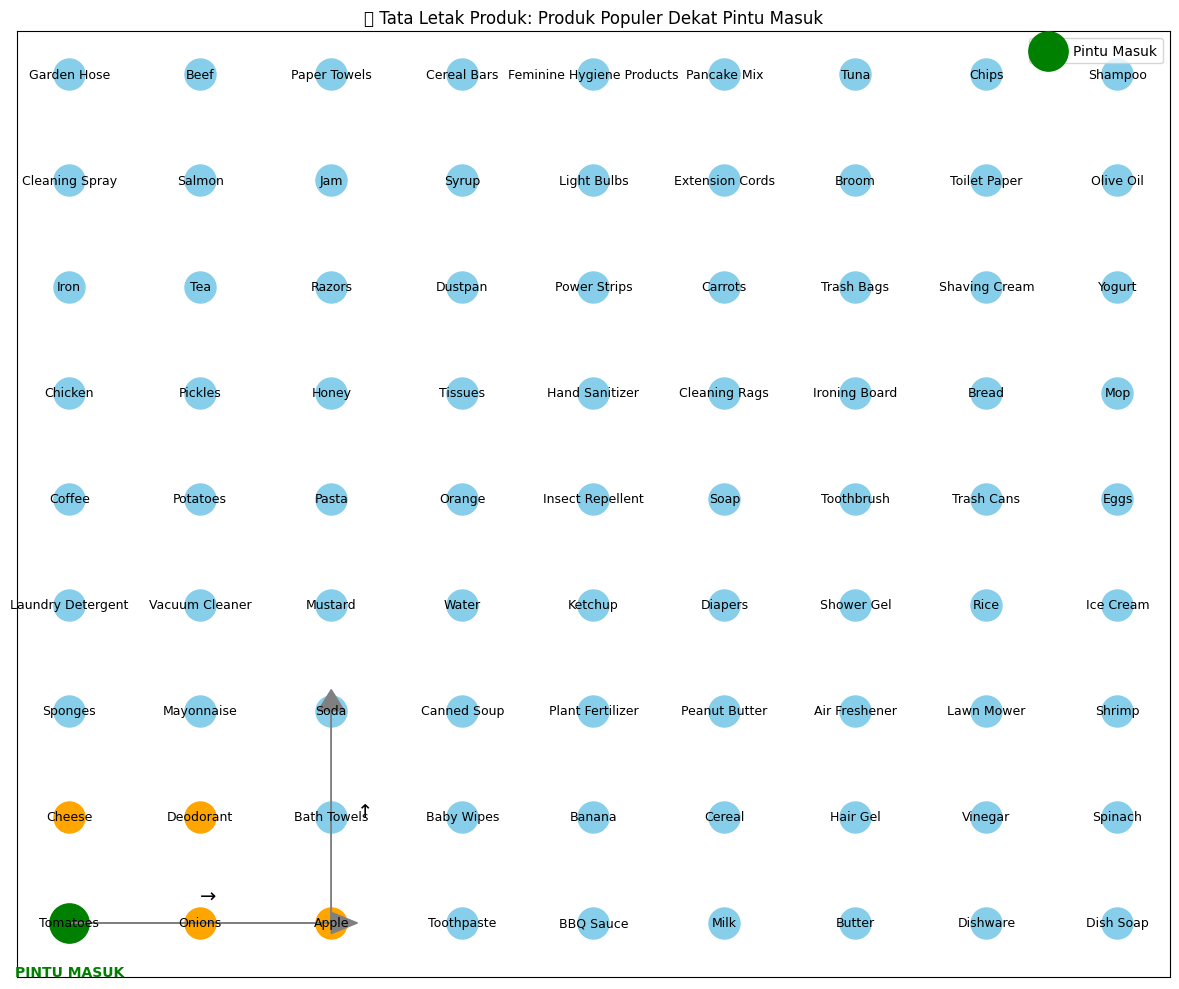

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ambil top produk dari TCR (yang sering dibeli)
produk_tcr = tcr.head(5)['product'].tolist()

# Produk dari aturan asosiasi (ARC)
produk_arc = list(set(arc_chart['antecedents']) | set(arc_chart['consequents']))

# Semua produk
semua_produk = list(set(produk_tcr) | set(produk_arc))

# Ukuran grid
grid_size = int(np.ceil(np.sqrt(len(semua_produk))))
posisi_produk = {}
grid_terisi = set()

# Fungsi cari posisi sekitar (untuk ARC)
def cari_posisi_terdekat(pos_awal):
    dxdy = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(1,1),(-1,1),(1,-1)]
    for dx, dy in dxdy:
        calon = (pos_awal[0] + dx, pos_awal[1] + dy)
        if 0 <= calon[0] < grid_size and 0 <= calon[1] < grid_size and calon not in grid_terisi:
            return calon
    return None

# 1. Tempatkan produk TCR di dekat pintu masuk
pintu_masuk = (0, 0)
antrian_pos = [(0, 0), (1, 0), (0, 1), (1, 1), (2, 0), (0, 2), (2, 1), (1, 2), (2, 2)]
for produk, pos in zip(produk_tcr, antrian_pos):
    posisi_produk[produk] = pos
    grid_terisi.add(pos)

# 2. Tempatkan produk hasil ARC dekat pasangannya
for _, row in arc_chart.iterrows():
    ant = row['antecedents']
    cons = row['consequents']

    for produk, pasangannya in [(ant, cons), (cons, ant)]:
        if produk not in posisi_produk and pasangannya in posisi_produk:
            pos_pasangan = posisi_produk[pasangannya]
            pos = cari_posisi_terdekat(pos_pasangan)
            if pos:
                posisi_produk[produk] = pos
                grid_terisi.add(pos)

# 3. Tempatkan produk lain yang belum diatur
for produk in semua_produk:
    if produk not in posisi_produk:
        for x in range(grid_size):
            for y in range(grid_size):
                if (x, y) not in grid_terisi:
                    posisi_produk[produk] = (x, y)
                    grid_terisi.add((x, y))
                    break
            if produk in posisi_produk:
                break

# --- VISUALISASI ---

plt.figure(figsize=(12, 10))

# Plot produk
for produk, (x, y) in posisi_produk.items():
    warna = 'orange' if produk in produk_tcr else 'skyblue'
    plt.scatter(x, y, s=500, c=warna)
    plt.text(x, y, produk, ha='center', va='center', fontsize=9)

# Tampilkan pintu masuk
plt.scatter(*pintu_masuk, s=800, c='green', label='Pintu Masuk')
plt.text(pintu_masuk[0], pintu_masuk[1] - 0.5, "PINTU MASUK", ha='center', fontsize=10, fontweight='bold', color='green')

# Tambahkan panah arah belanja
plt.arrow(pintu_masuk[0], pintu_masuk[1], 2, 0, head_width=0.2, head_length=0.2, fc='gray', ec='gray')
plt.arrow(pintu_masuk[0] + 2, pintu_masuk[1], 0, 2, head_width=0.2, head_length=0.2, fc='gray', ec='gray')
plt.text(pintu_masuk[0] + 1, pintu_masuk[1] + 0.2, '→', fontsize=14)
plt.text(pintu_masuk[0] + 2.2, pintu_masuk[1] + 1, '↑', fontsize=14)

# Format grid
plt.title("🛒 Tata Letak Produk: Produk Populer Dekat Pintu Masuk")
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()